In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from constants import *

In [2]:
def load_dataset(fname):
    toret = pd.read_csv(os.path.join(DATA_FOLDER, f"{fname}.csv"))
    return toret.set_index('Date')

In [3]:
smart_beta_prices = load_dataset("10y_prices_smart_beta")
overall_esg_prices = load_dataset("10y_prices_overall_esg")
env_esg_prices = load_dataset("10y_prices_env_esg")
soc_esg_prices = load_dataset("10y_prices_soc_esg")
idx_tracker_prices = load_dataset("10y_prices_index_trackers")
smart_beta_esg_prices = load_dataset("10y_prices_smart_beta_esg")
full_price_data = smart_beta_prices.merge(overall_esg_prices, left_index=True, right_index=True, how="outer") \
                            .merge(env_esg_prices, left_index=True, right_index=True, how="outer") \
                            .merge(soc_esg_prices, left_index=True, right_index=True, how="outer") \
                            .merge(idx_tracker_prices, left_index=True, right_index=True, how="outer") \
                            .merge(smart_beta_esg_prices, left_index=True, right_index=True, how="outer")

In [4]:
smart_beta_returns = smart_beta_prices.pct_change().dropna()
overall_esg_returns = overall_esg_prices.pct_change().dropna()
env_esg_returns = env_esg_prices.pct_change().dropna()
soc_esg_returns = soc_esg_prices.pct_change().dropna()
idx_tracker_returns = idx_tracker_prices.pct_change().dropna()
smart_beta_esg_returns = smart_beta_esg_prices.pct_change().dropna()
all_data = smart_beta_returns.merge(overall_esg_returns, left_index=True, right_index=True, how="outer") \
                            .merge(env_esg_returns, left_index=True, right_index=True, how="outer") \
                            .merge(soc_esg_returns, left_index=True, right_index=True, how="outer") \
                            .merge(idx_tracker_returns, left_index=True, right_index=True, how="outer") \
                            .merge(smart_beta_esg_returns, left_index=True, right_index=True, how="outer")

In [37]:
def get_return_and_volatility(dataset, colname, period=12):
    rets = dataset[colname].dropna().values
    return (1 + rets.mean()) ** 365 - 1, rets.std() * np.sqrt(period)

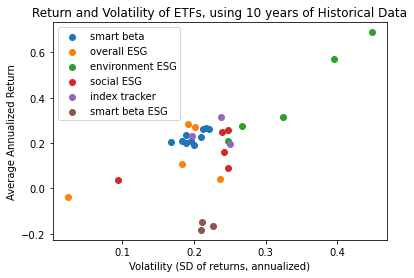

In [38]:
for group, name in [(SMART_BETA_TICKERS, "smart beta"),
              (OVERALL_ESG_TICKERS, "overall ESG"),
              (ENVIRONMENT_ESG_TICKERS, "environment ESG"),
              (SOCIAL_ESG_TICKERS, "social ESG"),
                (INDEX_TRACKER_TICKERS, "index tracker"),
                (SMART_BETA_ESG_TICKERS, "smart beta ESG")]:
    xs = []
    ys = []
    for ticker in group:
        y, x = get_return_and_volatility(all_data, ticker, period=365)
        # print(f"x: {x}, y: {y} for {ticker}")
        xs.append(x)
        ys.append(y)
    plt.scatter(xs, ys, label=name)
plt.title("Return and Volatility of ETFs, using 10 years of Historical Data")
plt.xlabel("Volatility (SD of returns, annualized)")
plt.ylabel("Average Annualized Return")
plt.legend();

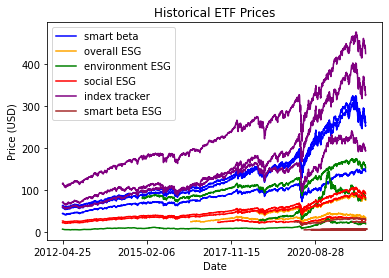

In [40]:
num_to_plot = 3
fig = plt.figure()
ax = fig.subplots()
for group, name, color in [(SMART_BETA_TICKERS[:num_to_plot], "smart beta", "blue"),
              (OVERALL_ESG_TICKERS[:num_to_plot], "overall ESG", "orange"),
              (ENVIRONMENT_ESG_TICKERS[:num_to_plot], "environment ESG", "green"),
              (SOCIAL_ESG_TICKERS[:num_to_plot], "social ESG", "red"),
                (INDEX_TRACKER_TICKERS[:num_to_plot], "index tracker", "purple"),
                (SMART_BETA_ESG_TICKERS[:num_to_plot], "smart beta ESG", "brown")]:
    first = True
    for ticker in group:
        if first:
            ax.plot(full_price_data[ticker].dropna(), color=color, label=name)
        else:
            ax.plot(full_price_data[ticker].dropna(), color=color)
        first = False
ax.set_title("Historical ETF Prices")
ax.set_ylabel("Price (USD)")
ax.set_xlabel("Date")
ax.set_xticks(ax.get_xticks()[::700])
plt.legend();

In [49]:
yf_aggregate_stats = pd.read_csv(os.path.join(DATA_FOLDER, "yf_agg_data.csv"))
three_yr_cols = ['3y return', '3y Beta', '3y Sharpe Ratio', '3y SD']

In [48]:
three_yr_stats = yf_aggregate_stats[three_yr_cols + ['Group']].dropna().groupby('Group').median()
three_yr_stats.columns = ["Median " + a for a in three_yr_stats.columns]
three_yr_stats

,Median 3y return,Median 3y Beta,Median 3y Sharpe Ratio,Median 3y SD
Group,,,,
Environment ESG,1.750,1.180,0.560,25.070
Index Tracker,1.580,1.030,0.800,19.800
Overall ESG,0.650,0.970,1.990,17.500
Smart Beta,1.405,0.985,0.995,18.530
Social ESG,1.320,1.015,0.735,18.115
